# Example 2: Visualizing the Haxby (fMRI) dataset with `kmapper` + `dyneusr` #


## 1 &nbsp;  `import` libraries ##

In [1]:
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
import numpy as np
import pandas as pd
import scipy as sp

import networkx as nx
from collections import Counter

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")

%matplotlib inline

### 1.1 &nbsp;  `import kmapper` ###

Here, we will use the KeplerMapper (`kmapper`) implementation of the Mapper algorithm. 

We will also import sklearn implementations of PCA and TSNE to use as (linear and non-linear) filter functions for Mapper.

In [5]:
import kmapper as km
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 

### 1.2 &nbsp;  `import dyneusr` ###

Note, `dyneusr` provides a wrapper around `kmapper` with support for caching each step of the Mapper algorithm. This will speed things up, especially when generating several shape graphs for different subjects. For a more detailed walk-through of how to generate a shape graph using `kmapper`, see `01_trefoil_knot/01_trefoil_knot.ipynb`. 

In [6]:
import dyneusr as ds

# kmapper wrappers
from dyneusr.mapper.wrappers import KMapperWrapper
from dyneusr.mapper.utils import optimize_cover, optimize_dbscan

## 2 &nbsp; Load `data` ##

In [7]:
from load_data import load_haxby, Bunch

Here, we actually use `nilearn.datasets.fetch_haxby` to fetch the files for the Haxby dataset. To make this note book more readable, we wrapped several steps into a single `load_haxby` function, stored in `load_data.py`. 

These steps include: 
1. fetching the Haxby dataset files; 
2. performing some preprocessing; and
3. storing the data for each subject as an `sklearn.datasets.base.Bunch` object for easy access. 

A list of these objects, one for each subject, is stored in a higher-level object, which also stores some other important meta-data shared across subjects. This higher-level object is returned by the function, `load_haxby`.

In [8]:
# load data for all 6 subjects, but only sessions 4-5
haxby = load_haxby(subjects=-1, sessions=[4,5], targets=None)

# extract subjects, print some information about them
subjects = haxby.subjects
for i, subject in enumerate(subjects):
    print(i, subject.name, subject.data.shape, subject.target.shape)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


0 subj1_sess4_5 (242, 577) (242, 9)
1 subj2_sess4_5 (242, 464) (242, 9)
2 subj3_sess4_5 (242, 307) (242, 9)
3 subj4_sess4_5 (242, 675) (242, 9)
4 subj5_sess4_5 (242, 422) (242, 9)
5 subj6_sess4_5 (242, 348) (242, 9)


### 2.1 &nbsp; Visualize the `data` ###

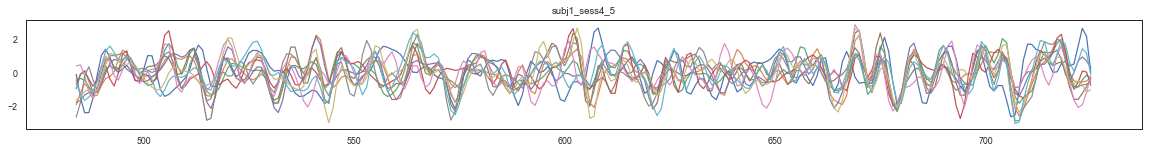

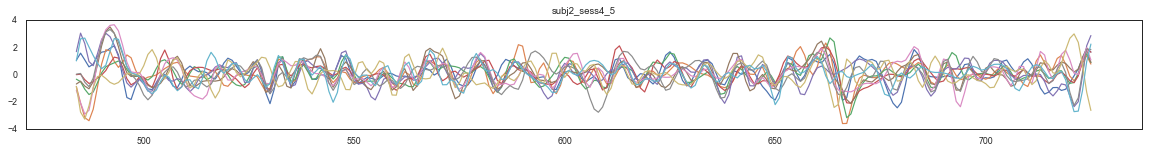

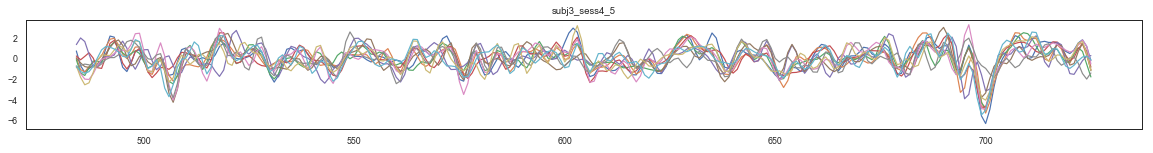

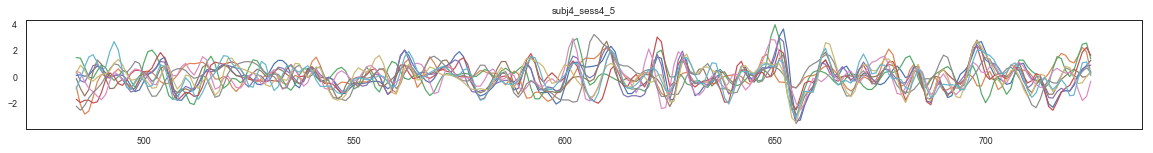

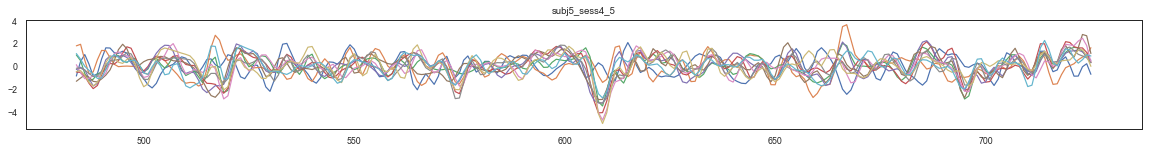

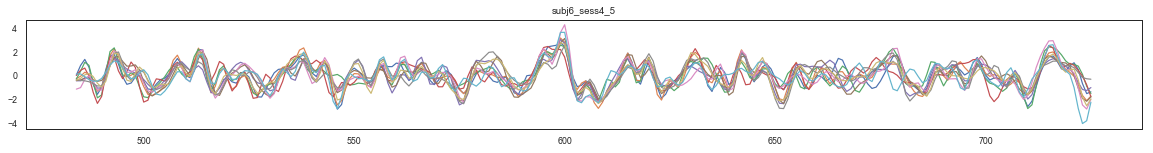

In [9]:
# inspect the first 10 voxels
for subject in haxby.subjects:
    _ = subject.data.iloc[:,:10].plot(
        figsize=(20,2), 
        legend=False, 
        title=subject.name
        )

### 2.2 &nbsp; Visualize the `meta` data ###

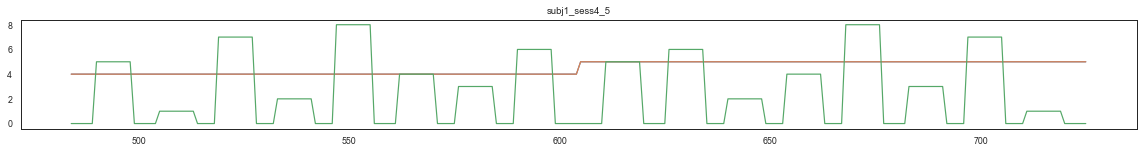

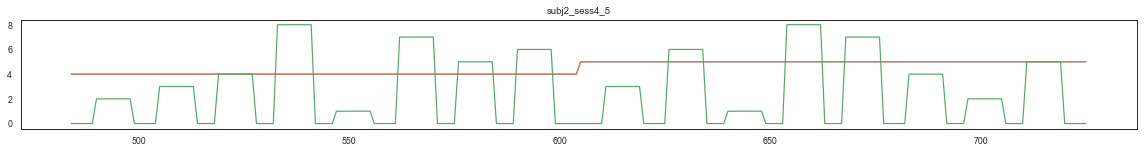

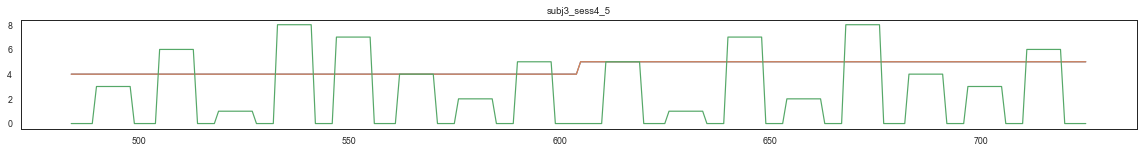

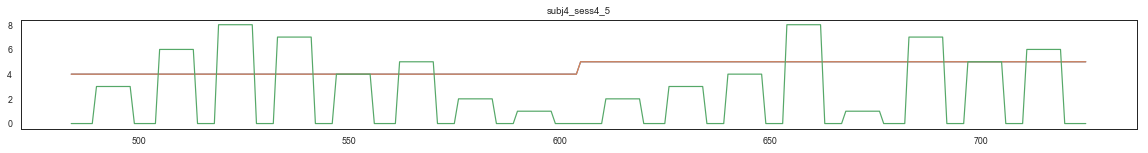

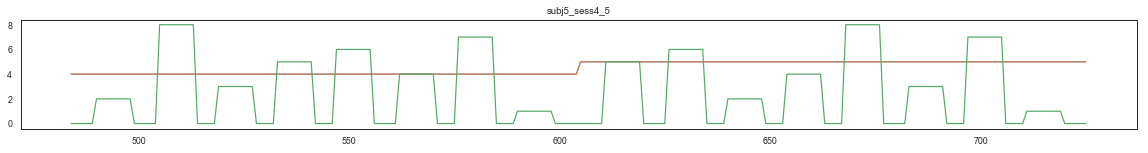

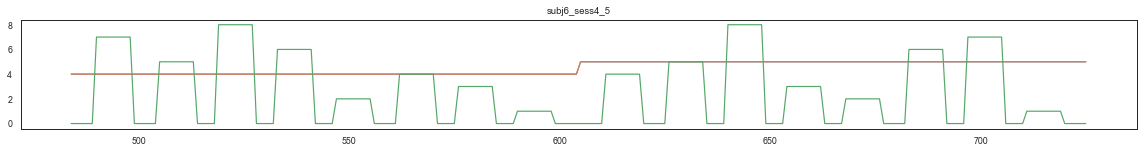

In [10]:
# inspect the first 10 voxels
for subject in haxby.subjects:
    _ = subject.meta.iloc[:,:10].plot(
        figsize=(20,2), 
        legend=False, 
        title=subject.name
        )


## 3 &nbsp; Generate a shape graph for each subject with `kmapper` ##

In [11]:
# loop over sessions, run for each
for i, subject in enumerate(subjects):
    
    ### Setup: extract X, y for each subject
    X = subject.data.values.copy()
    y = subject.target.copy()
    y = y.reindex(columns=haxby.target_names)
    print('[subject {}]'.format(subject.name))
    print(' X has shape: {}'.format(X.shape))
    print(' y has shape: {}'.format(y.shape))

    
    ### Run kmapper
    print("\nGenerating shape graph...")
    projection = TSNE(
        perplexity=50, random_state=0, 
        init='pca', method='exact'
        )
    clusterer = optimize_dbscan(X)
    cover = optimize_cover(
        X, r=15, g=0.67, 
        scale_r=not True, 
        scale_limits=True
        )
    print('\n projection = {}'.format(projection))
    print('\n clusterer = {}'.format(clusterer))
    print('\n cover = {}'.format(cover.__dict__))
    
    # run kmapper
    mapper = KMapperWrapper(
        memory='dyneusr_cache/{}'.format(subject.name)
        )    
    mapper.fit_lens(X, projection=projection)        
    mapper.fit_graph(data=X, clusterer=clusterer, cover=cover)
    
    # extract results
    lens = mapper.lens_.copy()
    graph = dict(mapper.graph_)
    
    
    ### Fit DyNeuGraph
    print("\nProcessing shape graph...")
    dG = ds.DyNeuGraph(
        G=graph, y=y, 
        labels=haxby.target_names, 
        colors=haxby.target_colors, 
        cmap=haxby.cmap
        )
       
    # store data
    subject.mapped = Bunch(
        data=X,
        lens=lens,
        graph=graph,
        dG=dG, X=X, y=y
        )
    subjects[i] = subject
    print()
    print()  

[subject subj1_sess4_5]
 X has shape: (242, 577)
 y has shape: (242, 9)

Generating shape graph...

 projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

 clusterer = DBSCAN(algorithm='auto', eps=26.3271381223901, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

 cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Processing shape graph...


label,group,value,row_count
rest,0,97.00,241
scissors,1,18.00,241
face,2,18.00,241
cat,3,18.00,241
shoe,4,18.00,241
house,5,18.00,241
scrambledpix,6,18.00,241
bottle,7,18.00,241
chair,8,18.00,241




[subject subj2_sess4_5]
 X has shape: (242, 464)
 y has shape: (242, 9)

Generating shape graph...

 projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

 clusterer = DBSCAN(algorithm='auto', eps=27.605001592992302, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

 cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Processing shape graph...


label,group,value,row_count
rest,0,97.00,241
scissors,1,18.00,241
face,2,18.00,241
cat,3,18.00,241
shoe,4,18.00,241
house,5,18.00,241
scrambledpix,6,18.00,241
bottle,7,18.00,241
chair,8,18.00,241




[subject subj3_sess4_5]
 X has shape: (242, 307)
 y has shape: (242, 9)

Generating shape graph...

 projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

 clusterer = DBSCAN(algorithm='auto', eps=24.668255970446275, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

 cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Processing shape graph...


label,group,value,row_count
rest,0,97.00,241
scissors,1,18.00,241
face,2,18.00,241
cat,3,18.00,241
shoe,4,18.00,241
house,5,18.00,241
scrambledpix,6,18.00,241
bottle,7,18.00,241
chair,8,18.00,241




[subject subj4_sess4_5]
 X has shape: (242, 675)
 y has shape: (242, 9)

Generating shape graph...

 projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

 clusterer = DBSCAN(algorithm='auto', eps=28.004985102867675, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

 cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Processing shape graph...


label,group,value,row_count
rest,0,97.00,241
scissors,1,18.00,241
face,2,18.00,241
cat,3,18.00,241
shoe,4,18.00,241
house,5,18.00,241
scrambledpix,6,18.00,241
bottle,7,18.00,241
chair,8,18.00,241




[subject subj5_sess4_5]
 X has shape: (242, 422)
 y has shape: (242, 9)

Generating shape graph...

 projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

 clusterer = DBSCAN(algorithm='auto', eps=23.616781132201332, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

 cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Processing shape graph...


label,group,value,row_count
rest,0,97.00,241
scissors,1,18.00,241
face,2,18.00,241
cat,3,18.00,241
shoe,4,18.00,241
house,5,18.00,241
scrambledpix,6,18.00,241
bottle,7,18.00,241
chair,8,18.00,241




[subject subj6_sess4_5]
 X has shape: (242, 348)
 y has shape: (242, 9)

Generating shape graph...

 projection = TSNE(angle=0.5, early_exaggeration=12.0, init='pca', learning_rate=200.0,
   method='exact', metric='euclidean', min_grad_norm=1e-07, n_components=2,
   n_iter=1000, n_iter_without_progress=300, perplexity=50, random_state=0,
   verbose=0)

 clusterer = DBSCAN(algorithm='auto', eps=20.11123226958869, leaf_size=15,
    metric='minkowski', metric_params=None, min_samples=2, n_jobs=1, p=2)

 cover = {'n_cubes': 17, 'perc_overlap': 0.67, 'limits': array([[-0.04466667,  1.04466667],
       [-0.04466667,  1.04466667]])}

Processing shape graph...


label,group,value,row_count
rest,0,97.00,241
scissors,1,18.00,241
face,2,18.00,241
cat,3,18.00,241
shoe,4,18.00,241
house,5,18.00,241
scrambledpix,6,18.00,241
bottle,7,18.00,241
chair,8,18.00,241


## 4 &nbsp; Visualize and annotate the shape graph with `dyneusr` ##

In [12]:
# select subject to inspect below
subject = subjects[0]

# copy inputs to Mapper
data = subject.data.copy()
meta = subject.meta.copy()

# copy outputs from Mapper
X = subject.mapped.X.copy()
y = subject.mapped.y.copy()
lens = subject.mapped.lens.copy()
dG = subject.mapped.dG

### 4.1 &nbsp; Visualize the `lens` ###

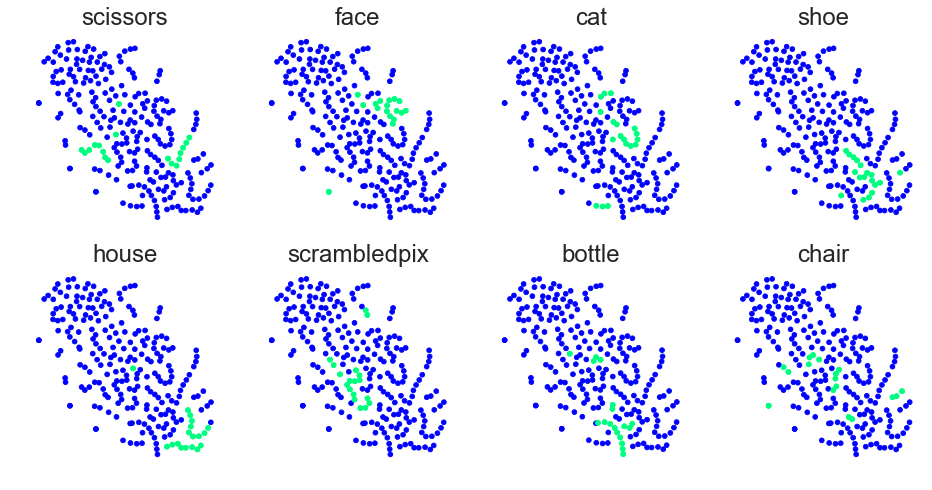

In [13]:
### View some quick results (e.g., the lens)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# loop over axis for each category of visual stimuli
c_cols = [_ for _ in y.columns if _ not in ['rest']]
for ax, stim in zip(np.ravel(axes), c_cols):

    # mask the stimuli for this category
    y_mask = (y[stim] == 1)
    
    # plot the lens, coloring only the category == stim
    ax.scatter(*lens.T, 
               c=y[stim], cmap='winter')    
    ax.scatter(*lens[y_mask].T, 
               c=y[y_mask][stim], cmap='winter_r')
    ax.set_title(stim, fontsize=24)    
    ax.axis('off')  

### 4.2 &nbsp; Visualize the stages of Mapper ###

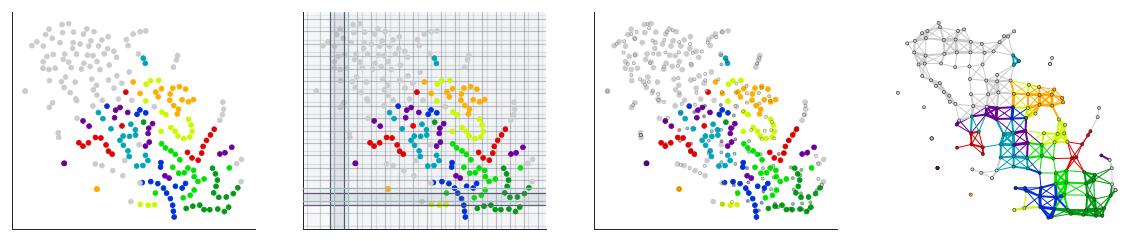

In [14]:
# we need to set y to a coloring
subject.y = subject.meta.target.values.copy()

# draw Mapper stages (and intermediates)
_ = ds.tools.networkx_utils.visualize_mapper_stages(
    data=subject, lens=lens, cover=cover, graph=graph,dG=dG,
    node_size=10, 
    )

### 4.3 &nbsp; Visualize the shape graph with `dyneusr`  ###

In [15]:
dG.visualize(
    'dyneusr_output_haxby_{}.html'.format(subject.name),
    show=True, port=8802
    )

Already serving localhost:8802 
[Force Graph] http://localhost:8802/dyneusr_output_haxby_subj1_sess4_5.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

### 4.4 &nbsp; Qualitative analysis ###

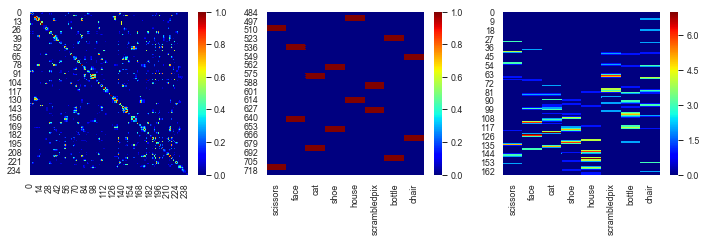

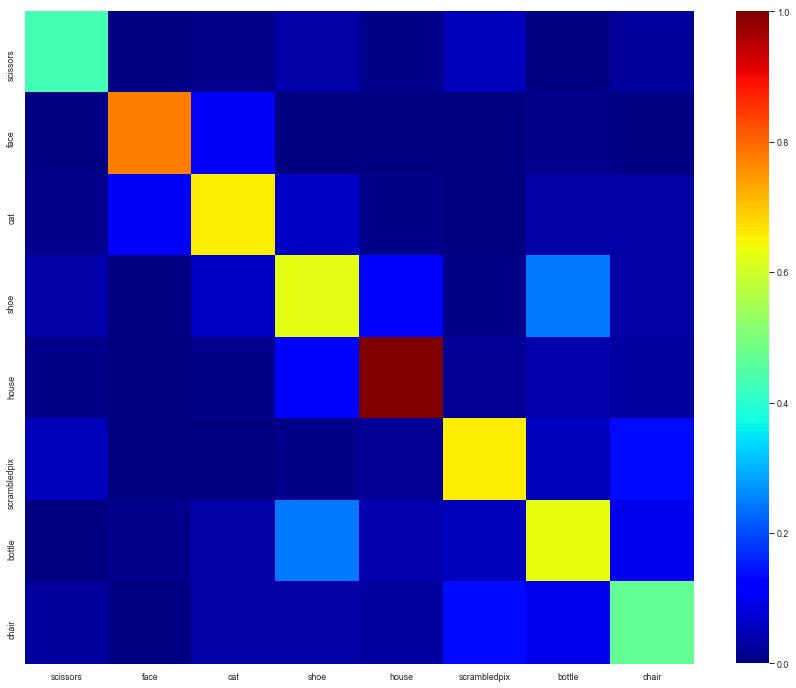

In [16]:
# define TR x Node, TR x TR, and TR x Stimuli matrices
TxN = dG.M.copy()
TxT = dG.TCM.copy()
TxS = y.copy().iloc[:, 1:]

# Compute Node x Stimuli, Stimuli x Stimuli
NxS = TxN.T @ TxS
SxS = NxS.T @ NxS
SxS /= SxS.max()


# plot the heatmaps
fig,axes = plt.subplots(1, 3, figsize=(12, 3))
sns.heatmap(TxT, ax=axes[0], cmap='jet')
sns.heatmap(TxS, ax=axes[1], cmap='jet', xticklabels=TxS.columns)
sns.heatmap(NxS, ax=axes[2], cmap='jet', xticklabels=TxS.columns)


# plot the heatmap of category similarity
fig,axes = plt.subplots(1, 1, figsize=(15, 12))
axes = np.ravel(axes)
sns.heatmap(SxS, ax=axes[0], cmap='jet', 
            xticklabels=TxS.columns, yticklabels=TxS.columns)

## 5 &nbsp; Anchor the shape graph to brain anatomy with `dyneusr` ##

### 5.1 &nbsp; Estimate average brain images for each time frame ###

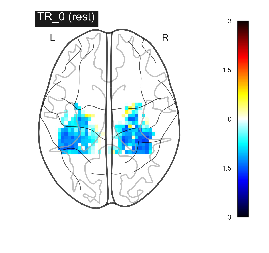

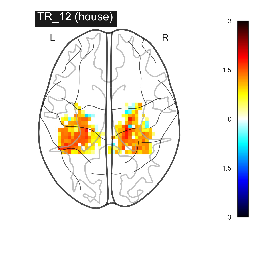

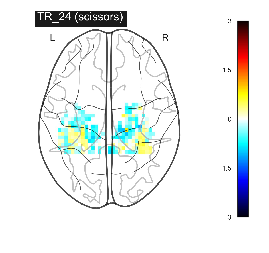

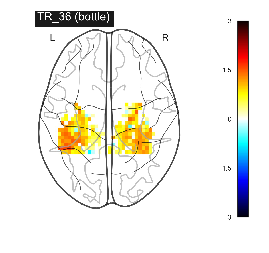

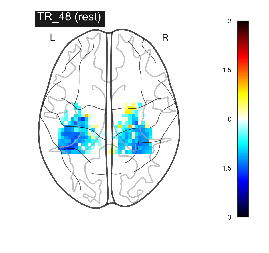

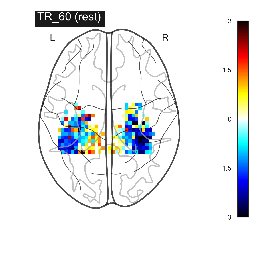

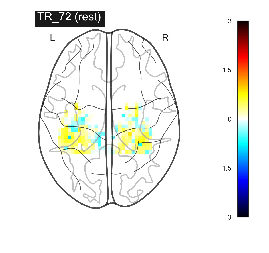

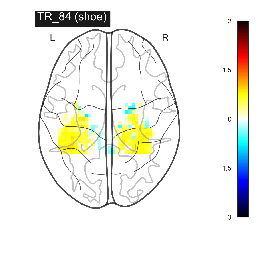

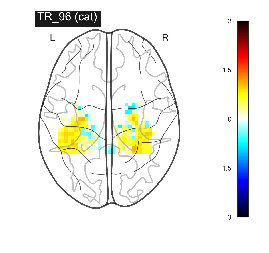

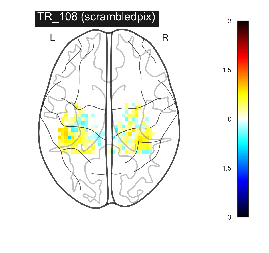

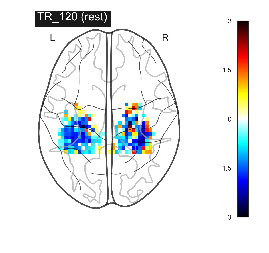

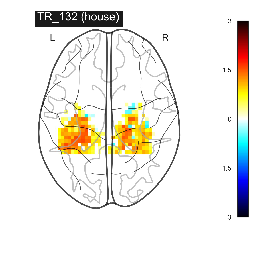

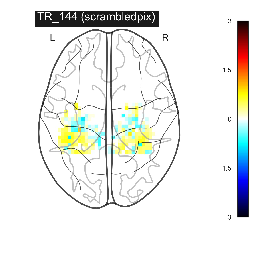

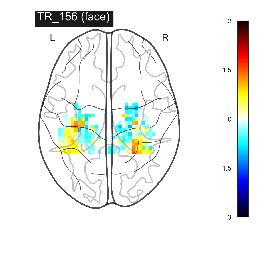

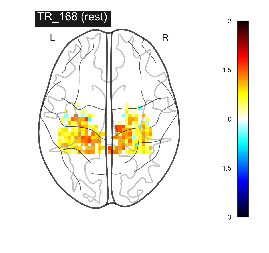

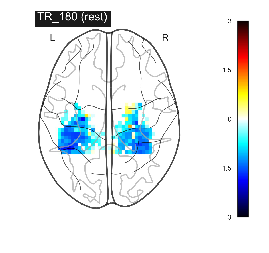

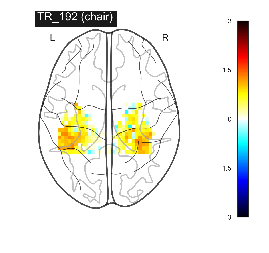

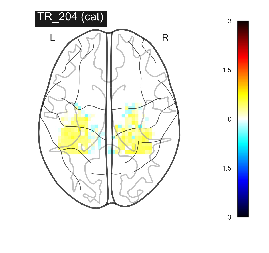

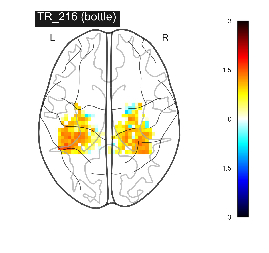

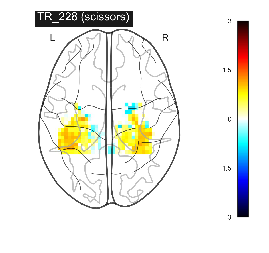

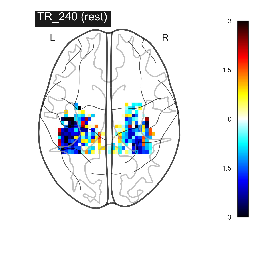

[done]


In [17]:
# get mixtures (time frames to average over)
mixtures = dG.mixtures_

# estimate and plot average brain images
brain_images = ds.tools.mixture.simple_mixtures(
    subject, mixtures=mixtures,
    save_dir='tooltips_{}'.format(subject.name), 
    prefix='TR_', targets=subject.meta.labels.tolist(),
    show_every_n=12, print_every_n=0,
    threshold=None, fwhm=None,
    kind='mean', mode='glass', figsize=(4, 4),
    plot_kws=dict(
        display_mode='z', cut_coords=1, 
        vmin=-3, vmax=3, threshold=0, colorbar=True, 
        ),
    )

### 5.2 &nbsp; Annotate nodes in the shape graph with the brain images ###


In [18]:
_ = dG.annotate(image=brain_images)

### 5.3 &nbsp; Visualize the shape graph with `dyneusr` (using the `d3-force` layout) ###

In [19]:
dG.visualize(
    'dyneusr_output_haxby_anat_{}.html'.format(subject.name), 
    show=True, port=8802
    )

Already serving localhost:8802 
[Force Graph] http://localhost:8802/dyneusr_output_haxby_anat_subj1_sess4_5.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

## 6 &nbsp; Capture temporal transitions in brain activity with `dyneusr` ##

In [20]:
# aggregate the TCMs into a single matrix
TCMs = np.array([_.mapped.dG.TCM.copy() for _ in subjects])
print("TCMs has shape:", TCMs.shape)

TCMs has shape: (6, 242, 242)


### 6.1 &nbsp; Visualize the temporal connectivity matrix (TCM) ###

Text(86.7,0.5,'Time frame (TR)')

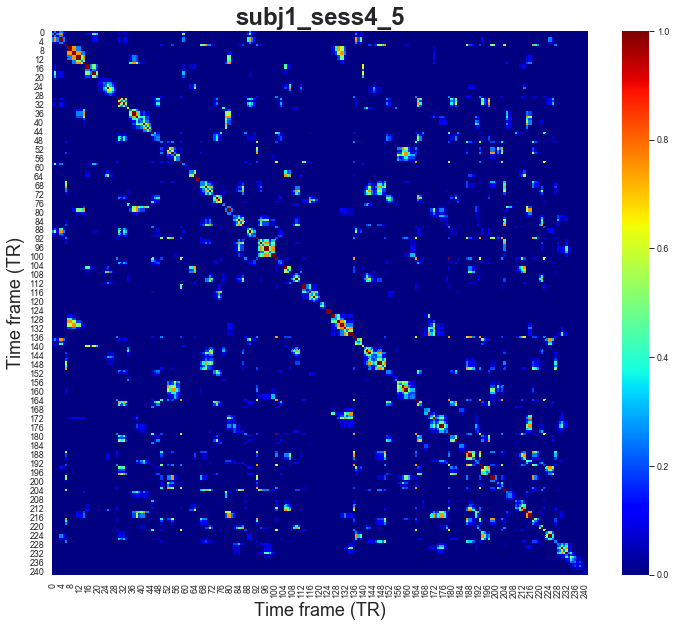

In [21]:
sns.heatmap(dG.TCM, cbar=True, cmap='jet', figure=plt.figure(figsize=(12,10)))
plt.title('{}'.format(subject.name), fontsize=24, fontweight='bold')
plt.xlabel('Time frame (TR)', fontsize=18)
plt.ylabel('Time frame (TR)', fontsize=18)

Text(86.7,0.5,'Time frame (TR)')

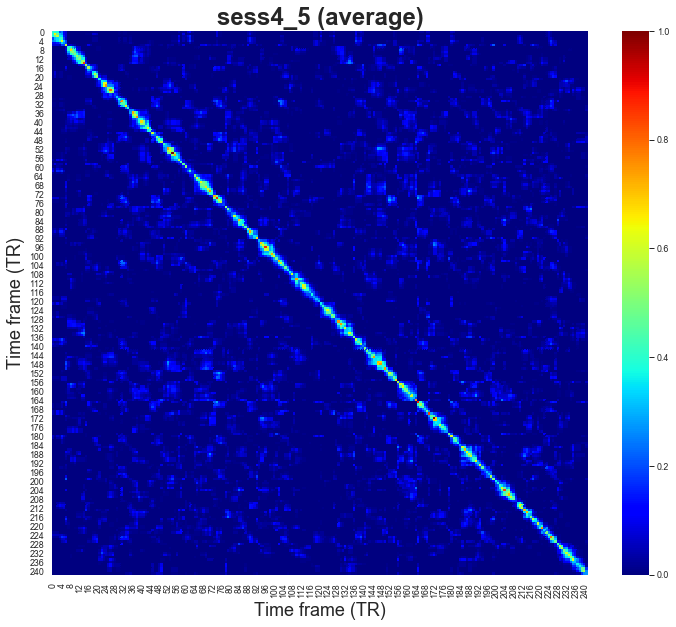

In [22]:
sns.heatmap(TCMs.mean(axis=0), cbar=True, cmap='jet', figure=plt.figure(figsize=(12,10)))
plt.title('{} (average)'.format(haxby.session_code), fontsize=24, fontweight='bold')
plt.xlabel('Time frame (TR)', fontsize=18)
plt.ylabel('Time frame (TR)', fontsize=18)

### 6.2 &nbsp; Visualize the normalized degree of nodes in the TCM over time ###


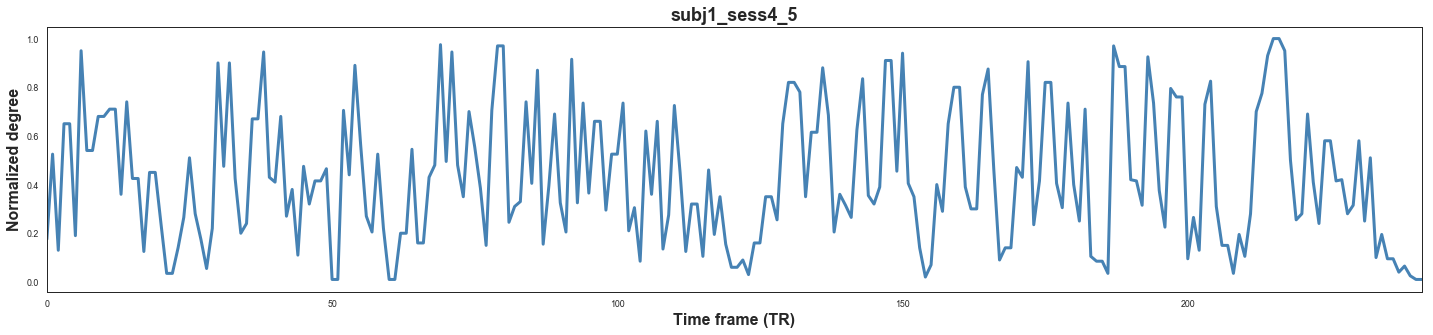

In [23]:
ds.visuals.plot_temporal_degree(dG.TCM, title=subject.name)

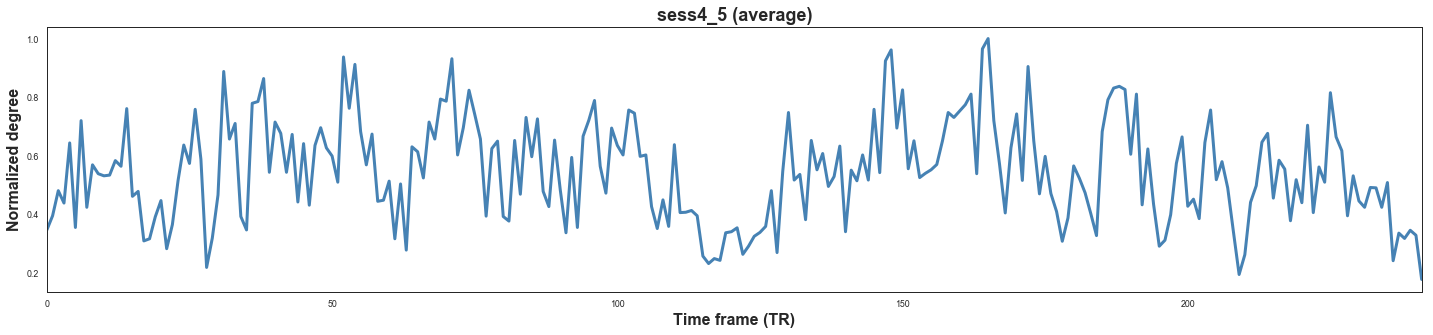

In [24]:
ds.visuals.plot_temporal_degree(TCMs.mean(axis=0), title='{} (average)'.format(haxby.session_code))

### 6.3 &nbsp; Visualize the degree of TCM for a single stimulus category ###


Extracting TCM for category=face, session=4, onset=49, offset=57


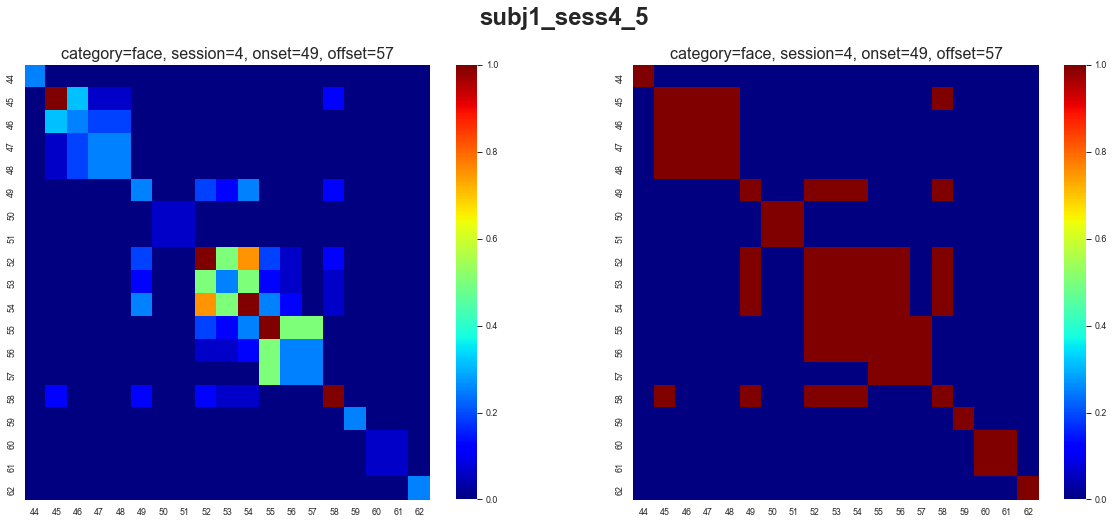

Extracting TCM for category=face, session=5, onset=156, offset=164


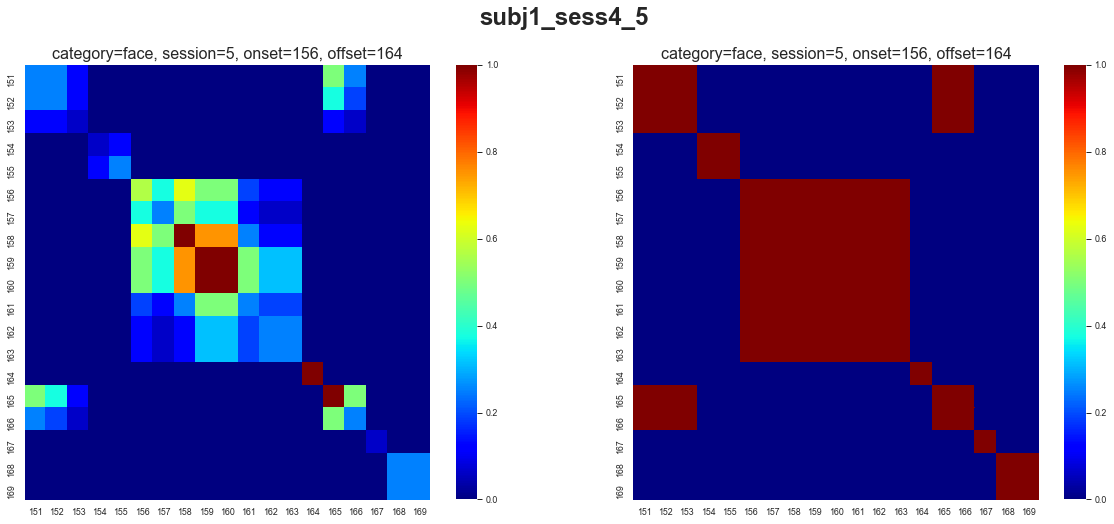

In [25]:
# define subject, category
subject = subjects[0]
target_name = 'face'

# mask target
target = subject.target.copy().reset_index(drop=True)
target = target.assign(data_id = target.index)
meta = subject.meta.copy().reset_index(drop=True)

# tcms
tcms = []
for session in [4, 5]:
    
    # define mask for each session
    target_mask = target[target_name].eq(1) 
    session_mask = meta.session.eq(session)
    target_index = target[(target_mask & session_mask)].index.values
    target_bounds = np.min(target_index), np.max(target_index)

    # include 5 rest beforeblock
    rest_before = (target.loc[target['rest'].eq(1)]
                   .data_id.ge(target_bounds[0]-5))
    rest_after = (target.loc[target['rest'].eq(1)]
                  .data_id.le(target_bounds[1]+5))
    rest_mask = (rest_before & rest_after)
    
    # mask targets for session, and rest before, after block
    target_mask = ((target_mask & session_mask) | (rest_mask & session_mask))
    target_mask_ix = np.ix_(target_mask, target_mask)
    trs = target_mask[target_mask].iloc[::].index.values

    # print some info
    print("Extracting TCM for category={}, session={}, onset={}, offset={}".format(
        target_name, session, trs[0]+5, trs[-1]-5
         ))
    
    # extract tcm
    tcm = subject.mapped.dG.TCM.copy()
    tcm = tcm[target_mask_ix]
    
    # convert to dataframe, save
    df_tcm = pd.DataFrame(tcm, columns=trs, index=trs)
    tcms.append(df_tcm)
   
       
    # plot heatmap
    figure, axes = plt.subplots(1, 2, figsize=(20,8))
    ax = sns.heatmap(df_tcm, cbar=True, cmap='jet', ax=axes[0])
    ax = sns.heatmap(df_tcm>0, cbar=True, cmap='jet', axes=axes[1]) 
    for ax in axes:
        ax.set_title("category={}, session={}, onset={}, offset={}".format(
            target_name, session, trs[0]+5, trs[-1]-5
            ), fontsize=16)
    plt.suptitle(subject.name, fontsize=24, fontweight='bold')
    plt.show()


# convert to array
tcms = np.array([_.values for _ in tcms])

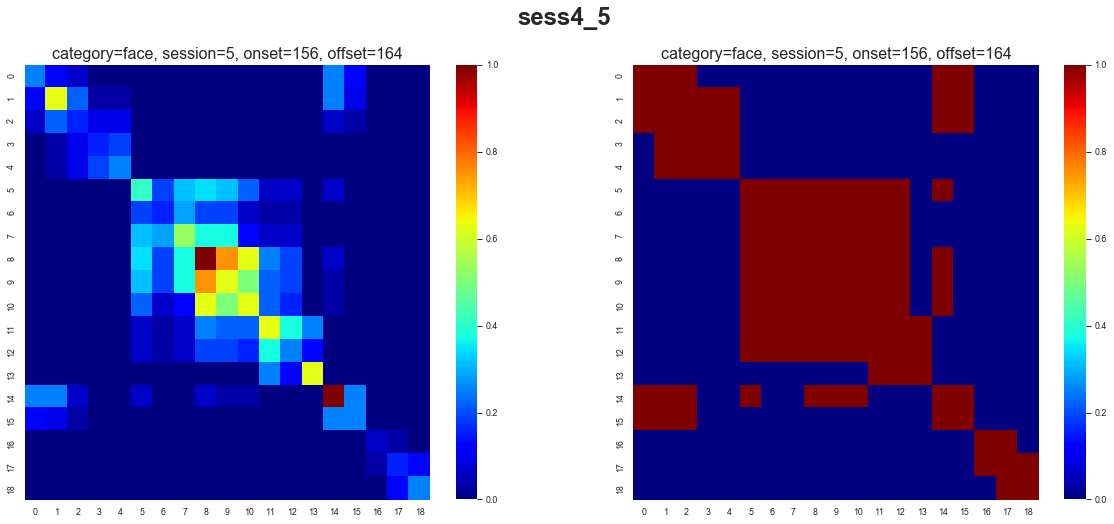

In [26]:
# plot heatmap
figure, axes = plt.subplots(1, 2, figsize=(20,8))
ax = sns.heatmap(tcms.mean(0), cbar=True, cmap='jet', ax=axes[0])
ax = sns.heatmap(tcms.mean(0)>0, cbar=True, cmap='jet', axes=axes[1]) 
for ax in axes:
    ax.set_title("category={}, session={}, onset={}, offset={}".format(
        target_name, session, trs[0]+5, trs[-1]-5
        ), fontsize=16)
plt.suptitle(haxby.session_code, fontsize=24, fontweight='bold')
plt.show()

